In [1]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from rnnconv import RnnConv

(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

In [2]:
model = tf.keras.Sequential() 

for i in range(2):

    model.add(layers.Conv2D(filters=64, kernel_size=3, input_shape=(3, 32, 32), activation = "relu", strides = (2, 2), padding='same', data_format='channels_first'))


    model.add(layers.Lambda(lambda x: tf.expand_dims(x,axis=1)))
    model.add(layers.ConvLSTM2D(filters=256, kernel_size=3, strides=(2, 2),  activation = "relu", padding='same', data_format='channels_first'))

    model.add(layers.Lambda(lambda x: tf.expand_dims(x,axis=1)))
    model.add(layers.ConvLSTM2D(filters=512, kernel_size=3, strides=(2, 2),  activation = "relu", padding='same', data_format='channels_first'))

    model.add(layers.Lambda(lambda x: tf.expand_dims(x,axis=1)))
    model.add(layers.ConvLSTM2D(filters=512, kernel_size=3, strides=(2, 2),  activation = "relu", padding='same', data_format='channels_first'))


    model.add(layers.Conv2D(filters=32, kernel_size=1, activation = "relu", strides = (1,1), padding='same', data_format='channels_first'))


    model.add(layers.Conv2D(filters=512, kernel_size=1, activation = "relu", strides = (1,1), padding='same', data_format='channels_first'))

    model.add(layers.Lambda(lambda x: tf.expand_dims(x,axis=1)))
    model.add(layers.ConvLSTM2D(filters=512, kernel_size=2, strides=(1, 1),  activation = "relu", padding='same', data_format='channels_first'))
    model.add(layers.Lambda(lambda x:tf.nn.depth_to_space(x,2,data_format='NCHW')))

    model.add(layers.Lambda(lambda x: tf.expand_dims(x,axis=1)))
    model.add(layers.ConvLSTM2D(filters=512, kernel_size=3, strides=(1, 1),  activation = "relu", padding='same', data_format='channels_first'))
    model.add(layers.Lambda(lambda x:tf.nn.depth_to_space(x,2,data_format='NCHW')))

    model.add(layers.Lambda(lambda x: tf.expand_dims(x,axis=1)))
    model.add(layers.ConvLSTM2D(filters=256, kernel_size=3, strides=(1, 1),  activation = "relu", padding='same', data_format='channels_first'))
    model.add(layers.Lambda(lambda x:tf.nn.depth_to_space(x,2,data_format='NCHW')))

    model.add(layers.Lambda(lambda x: tf.expand_dims(x,axis=1)))
    model.add(layers.ConvLSTM2D(filters=128, kernel_size=3, strides=(1, 1),  activation = "relu", padding='same', data_format='channels_first'))
    model.add(layers.Lambda(lambda x:tf.nn.depth_to_space(x,2,data_format='NCHW')))

    model.add(layers.Conv2D(filters=3, kernel_size=1, activation = "relu", strides = (1,1), padding='same', data_format='channels_first'))

In [3]:
model.compile(optimizer='adam', loss='mse', metrics=['mse','mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 16, 16)        1792      
_________________________________________________________________
lambda (Lambda)              (None, 1, 64, 16, 16)     0         
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, 256, 8, 8)         2950144   
_________________________________________________________________
lambda_1 (Lambda)            (None, 1, 256, 8, 8)      0         
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 512, 4, 4)         14157824  
_________________________________________________________________
lambda_2 (Lambda)            (None, 1, 512, 4, 4)      0         
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 512, 2, 2)         1

In [4]:
train_images_ = tf.convert_to_tensor(train_images.reshape((-1,3,32,32)))
model3 = model.fit(train_images_[0:100], train_images_[0:100], batch_size=64, epochs=10)

Epoch 1/10
2/2 [==============================] - 10s 5s/step - loss: 0.2610 - mse: 0.2610 - mae: 0.4503
Epoch 2/10
2/2 [==============================] - 8s 4s/step - loss: 0.2584 - mse: 0.2584 - mae: 0.4475
Epoch 3/10
2/2 [==============================] - 8s 4s/step - loss: 0.2557 - mse: 0.2557 - mae: 0.4445
Epoch 4/10
2/2 [==============================] - 8s 4s/step - loss: 0.2529 - mse: 0.2529 - mae: 0.4413
Epoch 5/10
2/2 [==============================] - 8s 4s/step - loss: 0.2498 - mse: 0.2498 - mae: 0.4378
Epoch 6/10
2/2 [==============================] - 8s 4s/step - loss: 0.2464 - mse: 0.2464 - mae: 0.4339
Epoch 7/10
2/2 [==============================] - 8s 4s/step - loss: 0.2426 - mse: 0.2426 - mae: 0.4296
Epoch 8/10
2/2 [==============================] - 8s 4s/step - loss: 0.2383 - mse: 0.2383 - mae: 0.4246
Epoch 9/10
2/2 [==============================] - 8s 4s/step - loss: 0.2332 - mse: 0.2332 - mae: 0.4187
Epoch 10/10
2/2 [==============================] - 8s 4s/step -

(32, 32, 3)


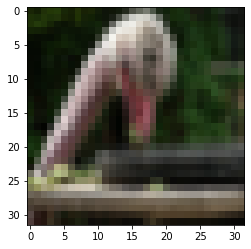

In [21]:
from matplotlib import pyplot as plt

img = train_images_[400]
img_ = img.numpy().reshape((32,32,3))
plt.imshow(img_, interpolation='nearest')
print(img_.shape)
plt.show()

In [39]:
img_pred = test_images[0:10].reshape((10,3,32,32,))
full = model.predict(img_pred)

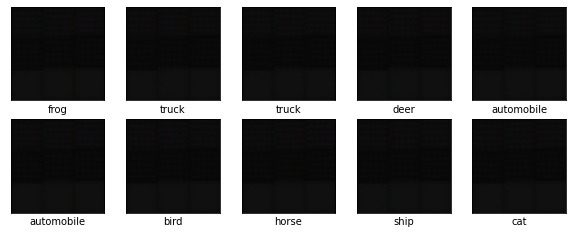

In [42]:
full_pred = full.reshape((10,32,32,3))

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(full_pred[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

In [50]:
full_pred[0]

array([[[0.03977442, 0.03715859, 0.04382056],
        [0.04143263, 0.04402516, 0.04152878],
        [0.04469274, 0.04233696, 0.04448564],
        ...,
        [0.04971454, 0.05158265, 0.04900876],
        [0.05076823, 0.04908484, 0.04991831],
        [0.04764257, 0.04308359, 0.04265699]],

       [[0.04316856, 0.02919795, 0.05019284],
        [0.03229294, 0.05063438, 0.03247417],
        [0.05182819, 0.03307391, 0.05155726],
        ...,
        [0.03385922, 0.05223912, 0.03342899],
        [0.05222492, 0.03347666, 0.05050237],
        [0.03260416, 0.04419956, 0.02993605]],

       [[0.04531387, 0.04179687, 0.05171309],
        [0.04960024, 0.05271434, 0.04980839],
        [0.05367026, 0.05167744, 0.05370404],
        ...,
        [0.05109346, 0.05425617, 0.05043093],
        [0.05338173, 0.05022305, 0.05202623],
        [0.04868109, 0.04440637, 0.04294545]],

       ...,

       [[0.05270706, 0.05059877, 0.06209105],
        [0.06006485, 0.06346424, 0.06110201],
        [0.06482022, 0